In [ ]:
!pip install scikit-learn==1.0.2 # Downgrade to version 1.0.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pwd
%cd drive/MyDrive/LEAD/

[Errno 2] No such file or directory: 'drive/MyDrive/LEAD/'
/content/drive/MyDrive/LEAD


In [ ]:
!pip install xgboost



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm, trange
from datetime import datetime

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
from sklearn.metrics import make_scorer,classification_report, roc_auc_score, roc_curve, auc, log_loss, accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

import random

from tensorflow.keras.models import  load_model
import json


import warnings
warnings.filterwarnings('ignore')

import os
import pickle

from collections import Counter

from sklearn.utils.class_weight import compute_class_weight





In [ ]:
# train=pd.read_csv('train_meta_one-hot.csv')
train=pd.read_csv('train_meta_label.csv')

In [ ]:
train.shape
train.head()

,building_id,timestamp,meter_reading,square_feet,year_built,floor_count,primary_use_label,anomaly,meter_reading_missing,year_built_missing,floor_count_missing
0,1,2016-01-01 00:00:00,0.0,2720,2004.0,1.0,0,0,1,0,1
1,32,2016-01-01 00:00:00,0.0,48392,2005.0,1.0,6,0,1,0,1
2,41,2016-01-01 00:00:00,0.0,93860,1968.0,1.0,6,0,1,0,1
3,55,2016-01-01 00:00:00,0.0,16726,2011.0,1.0,6,0,1,0,1
4,69,2016-01-01 00:00:00,0.0,387638,2000.0,1.0,8,0,1,0,1


([<matplotlib.patches.Wedge at 0x7880c4d944c0>,
 [Text(1.0795102377415011, 0.21132355905409178, 'Null'),
  Text(-1.0795102476342697, -0.21132350851856982, 'Filled')])

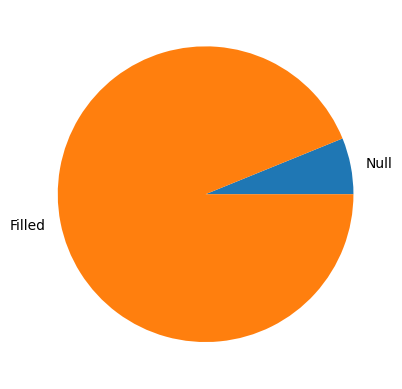

In [ ]:
# k = train.isnull().sum().sum()
# plt.pie([k, train.shape[0]-k], labels=['Null', 'Filled'])
# #         , colors=sb.color_palette('bright'), autopct='%.0f%%')
# # plt.show()

In [ ]:
# plt.subplots(figsize=(15,5))
# plt.subplot(1,2,1)
# sb.countplot(x=train['anomaly'])
# plt.subplot(1,2,2)
# data = train['anomaly'].value_counts()
# plt.pie(data, labels=['Normal', 'Anomalous'], colors=sb.color_palette('bright'), autopct='%.0f%%')
# plt.show()

In [ ]:
# mean_reading = train.groupby('building_id')['meter_reading'].mean()

In [ ]:
# plt.figure(figsize=(20,10))
# mean_reading.plot.bar()
# plt.xticks([])
# plt.show()

In [ ]:
# mean_reading.idxmax()

In [ ]:
# print(train.columns)

In [ ]:
def add_date_time(data):
  if 'timestamp' in data.columns:
    new = data['timestamp'].str.split(' ', n=1, expand=True)
    data['date'] = new[0]
    data['time'] = new[1]
    data['time'] = data['time'].str[:2].astype(int)
    data = data.drop(['timestamp'], axis=1)
  else:
    print("Skipping")

  data['date'] = data['date'].astype(str)

  return data

def add_month_day(data):
  data['month'] = data['date'].str[5:7].astype(int)
  data['day'] = data['date'].str[-2:].astype(int)
  data = data.drop(['date'], axis=1)

  return data

train = add_date_time(train)
train = add_month_day(train)
train.head()

,building_id,meter_reading,square_feet,year_built,floor_count,primary_use_label,anomaly,meter_reading_missing,year_built_missing,floor_count_missing,time,month,day
0,1,0.0,2720,2004.0,1.0,0,0,1,0,1,0,1,1
1,32,0.0,48392,2005.0,1.0,6,0,1,0,1,0,1,1
2,41,0.0,93860,1968.0,1.0,6,0,1,0,1,0,1,1
3,55,0.0,16726,2011.0,1.0,6,0,1,0,1,0,1,1
4,69,0.0,387638,2000.0,1.0,8,0,1,0,1,0,1,1


In [ ]:
# plt.figure(figsize=(15,5))
# mean_reading_by_time = train.groupby('time')['meter_reading'].mean()
# mean_reading_by_time.plot.bar()
# plt.title('Mean usage hourly.', fontsize=20)
# plt.show()

In [ ]:
# plt.figure(figsize=(15,5))
# train.groupby('month').mean()['meter_reading'].plot.bar()
# plt.title('Mean usage monthly.', fontsize=20)
# plt.show()

In [ ]:
# plt.figure(figsize=(15,5))
# train.groupby('day').mean()['meter_reading'].plot.bar()
# plt.title('Mean usage daily.', fontsize=20)
# plt.show()

In [ ]:
def weekend_or_weekday(year,month,day):

    d = datetime(year,month,day)
    if d.weekday()>4:
        return 1
    else:
        return 0


train['weekend'] = train.apply(lambda x:\
                               weekend_or_weekday(int(2016),int(x['month']),int(x['day'])),axis=1)
train.head()

,building_id,meter_reading,square_feet,year_built,floor_count,primary_use_label,anomaly,meter_reading_missing,year_built_missing,floor_count_missing,time,month,day,weekend
0,1,0.0,2720,2004.0,1.0,0,0,1,0,1,0,1,1,0
1,32,0.0,48392,2005.0,1.0,6,0,1,0,1,0,1,1,0
2,41,0.0,93860,1968.0,1.0,6,0,1,0,1,0,1,1,0
3,55,0.0,16726,2011.0,1.0,6,0,1,0,1,0,1,1,0
4,69,0.0,387638,2000.0,1.0,8,0,1,0,1,0,1,1,0


In [ ]:
# train['weekend'].value_counts()

In [ ]:
# data = train.groupby('weekend')['meter_reading'].mean()
# plt.pie(data, labels=['Weekday Mean Usage', 'Weekend Mean Usage']\
#         , colors=sb.color_palette('bright'))
# plt.show()

In [ ]:
# def impute_nulls(data):
#     mean_reading = data.groupby('building_id').mean()['meter_reading']
#     building_id = mean_reading.index
#     values = mean_reading.values

#     for i, idx in enumerate(building_id):
#         data[data['building_id']==idx] = data[data['building_id']==idx].fillna(values[i])

#     return data

# train = impute_nulls(train)

In [ ]:
neg = train[train['anomaly'] == 0]
pos = train[train['anomaly'] == 1]

print(neg.shape, pos.shape)
negs1 = neg.sample(n = 37296, random_state=10)
negs2 = neg.sample(n = 37296, random_state=20)
df_eq = pd.concat([neg,pos], axis=0)


print(df_eq.shape)

(1712198, 14) (37296, 14)
(1749494, 14)


In [ ]:
print(df_eq.columns)

Index(['building_id', 'meter_reading', 'square_feet', 'year_built',
       'floor_count', 'primary_use_label', 'anomaly', 'meter_reading_missing',
       'year_built_missing', 'floor_count_missing', 'time', 'month', 'day',
       'weekend'],
      dtype='object')


In [ ]:
train_data, test_data = train_test_split(df_eq, test_size=0.3, stratify=df_eq['anomaly'], random_state=10)

X_train = train_data.drop(['anomaly', 'building_id'], axis=1)
Y_train = train_data['anomaly']

X_test_total = test_data.drop(['anomaly', 'building_id'], axis=1)
Y_test_total = test_data['anomaly']

X_val, X_test, Y_val, Y_test = train_test_split(
    X_test_total, Y_test_total, test_size=0.1, stratify=Y_test_total, random_state=10
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


###
X_val_temp=X_val
Y_val_temp=Y_val
X_test_temp=X_test
Y_test_temp=Y_test
###

In [ ]:
print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_val:", X_val.shape, "Y_val:", Y_val.shape)
print("X_test:", X_test.shape, "Y_test:", Y_test.shape)


X_train: (1224645, 12) Y_train: (1224645,)
X_val: (472364, 12) Y_val: (472364,)
X_test: (52485, 12) Y_test: (52485,)


In [ ]:
#######################################
def sigmoid(z):
    return 1/(1+np.exp(-z))


def compute_loss(X, y, weight, bias):
    m=X.shape[0]
    z=np.dot(X, weight)+bias
    y_hat=sigmoid(z)
    pos_weight=df_eq.shape[0]/(2*pos.shape[0])
    neg_weight=df_eq.shape[0]/(2*neg.shape[0])
    loss=-(1/m)*np.sum(pos_weight*y*np.log(y_hat)+neg_weight*(1-y)*np.log(1-y_hat))
    return loss

def fit(X_train, Y_train, X_val, Y_val, learning_rate, iteration):
    weight=np.zeros(X_train.shape[1])
    bias=0
    train_losses=[]
    val_losses=[]
    m=X_train.shape[0]
    for i in range(iteration):
        z=np.dot(X_train, weight)+bias
        y_hat=sigmoid(z)
        dw=(1/m)*np.dot(X_train.T, (y_hat-Y_train))
        db=(1/m)*np.sum(y_hat-Y_train)
        weight-=learning_rate*dw
        bias-=learning_rate*db
        train_loss=compute_loss(X_train, Y_train, weight, bias)
        val_loss=compute_loss(X_val, Y_val, weight, bias)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Iteration {i}, Train loss: {train_loss}, Validation loss: {val_loss}")
        save_model(weight, bias, train_losses, val_losses)

def save_model(weight, bias, train_losses, val_losses):
    folder='logistic_op'
    if not os.path.exists(folder):
        os.makedirs(folder)
    weight_path=os.path.join(folder, 'logistic_weight.pkl')
    loss_path=os.path.join(folder, 'logistic_loss.pkl')
    with open(weight_path, 'wb') as f:
        pickle.dump({"weight":weight, "bias":bias}, f)
    with open(loss_path, 'wb') as f:
        pickle.dump({"train_losses":train_losses, "val_losses":val_losses}, f)


logistic_model={
    "learning_rate":0.05,
    "iteration":600
}
fit(X_train, Y_train, X_val, Y_val, logistic_model["learning_rate"], logistic_model["iteration"])



Iteration 0, Train loss: 0.6926337773996135, Validation loss: 0.6926398670620396
Iteration 1, Train loss: 0.6921331483820707, Validation loss: 0.692145129295391
Iteration 2, Train loss: 0.6916449423254487, Validation loss: 0.6916626214486291
Iteration 3, Train loss: 0.6911688341280837, Validation loss: 0.6911920237179701
Iteration 4, Train loss: 0.6907045049191762, Validation loss: 0.690733022452338
Iteration 5, Train loss: 0.6902516421829492, Validation loss: 0.69028531027262
Iteration 6, Train loss: 0.6898099398578313, Validation loss: 0.6898485861665548
Iteration 7, Train loss: 0.6893790984122202, Validation loss: 0.6894225555607778
Iteration 8, Train loss: 0.6889588248983843, Validation loss: 0.6890069303715465
Iteration 9, Train loss: 0.688548832986045, Validation loss: 0.6886014290356587
Iteration 10, Train loss: 0.6881488429771658, Validation loss: 0.6882057765230553
Iteration 11, Train loss: 0.6877585818034355, Validation loss: 0.6878197043325631
Iteration 12, Train loss: 0.687

Da load


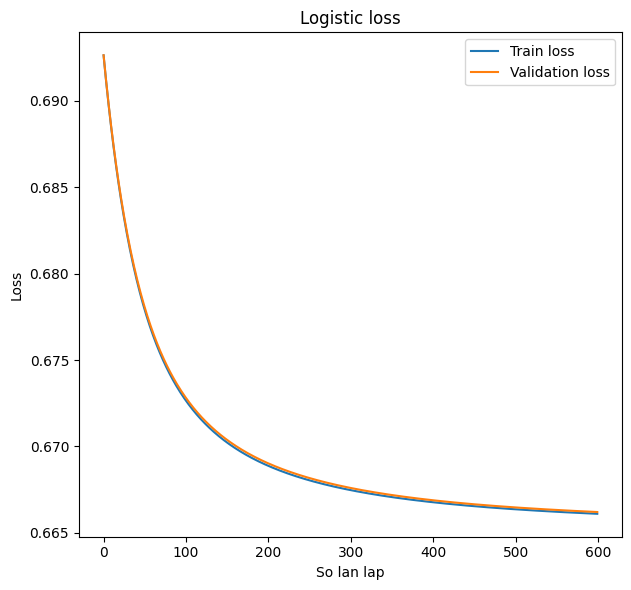

In [ ]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

# def compute_accuracy(X, y, weight, bias):
#     z = np.dot(X, weight) + bias
#     y_hat = sigmoid(z)
#     predictions = (y_hat >= 0.5).astype(int)
#     accuracy = np.mean(predictions == y)
#     return accuracy

def load_model():
    folder='logistic_op'
    weight_path=os.path.join(folder, 'logistic_weight.pkl')
    loss_path=os.path.join(folder, 'logistic_loss.pkl')

    with open(weight_path, 'rb') as f:
        weights=pickle.load(f)

    with open(loss_path, 'rb') as f:
        losses=pickle.load(f)

    print("Da load")
    logistic_model={
        "weight": weights["weight"],
        "bias": weights["bias"],
        "train_losses": losses["train_losses"],
        "val_losses": losses["val_losses"]
    }

    return logistic_model

def plot_model(logistic_model, X_train, Y_train, X_val, Y_val):
    weight=logistic_model["weight"]
    bias=logistic_model["bias"]

    # train_accuracy=compute_accuracy(X_train, Y_train, weight, bias)
    # val_accuracy=compute_accuracy(X_val, Y_val, weight, bias)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(logistic_model["train_losses"])), logistic_model["train_losses"], label='Train loss')
    plt.plot(range(len(logistic_model["val_losses"])), logistic_model["val_losses"], label='Validation loss')
    plt.xlabel('So lan lap')
    plt.ylabel('Loss')
    plt.title('Logistic loss')
    plt.legend()
    # plt.ylim(0, 1.2)

    plt.tight_layout()
    plt.show()

    # print(f"Train accuracy (Logistic): {train_accuracy}")
    # print(f"Validation accuracy (Logistic): {val_accuracy}")

def predict_logis(X, model):
    weight=model["weight"]
    bias=model["bias"]
    z=np.dot(X, weight) + bias
    y_hat=sigmoid(z)
    return y_hat

logistic_model=load_model()
plot_model(logistic_model, X_train, Y_train, X_val, Y_val)



In [ ]:
from sklearn.metrics import precision_recall_curve, recall_score, precision_score

def custom_scorer(y_true, y_pred_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

    for i in range(len(thresholds)):
        if precision[i]>=0.7:
            optimal_idx=i
            break

    optimal_threshold=thresholds[optimal_idx]

    y_pred=(y_pred_prob>=optimal_threshold).astype(int)

    recall_at_optimal=recall_score(y_true, y_pred)

    return recall_at_optimal


custom_recall_scorer=make_scorer(custom_scorer, needs_proba=True)

param_dist = {
    'scale_pos_weight': [1.0] + list(np.linspace(10, 100, 10)),
    'max_depth': [3, 5, 6, 7, 9],
    'learning_rate': [0.3] + list(np.linspace(0.01, 0.5, 10)),
    'n_estimators': [100, 150, 200, 300],
    'gamma': [0, 0.1, 0.2, 0.5, 1.0],
}

xgb_model=XGBClassifier(objective="binary:logistic")

random_search=RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring=custom_recall_scorer,
    n_iter=50,
    cv=3,
    verbose=3,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, Y_train)

print(random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'scale_pos_weight': 20.0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.2}


In [ ]:
xgb_model=xgb.XGBClassifier(objective="binary:logistic",
                            max_depth=9,
                            learning_rate=0.3,
                            n_estimators=300,
                            scale_pos_weight=20,
                            gamma=0.2,
                            min_child_weight=0)

xgb_model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_val, Y_val)])


xgb_model.save_model("xgb_weight.json")

evals_result = xgb_model.evals_result()

with open("xgb_loss.json", "w") as f:
    json.dump(evals_result, f)

# print("Model and loss history saved successfully.")


[0]	validation_0-logloss:0.31457	validation_1-logloss:0.31454
[1]	validation_0-logloss:0.26413	validation_1-logloss:0.26413
[2]	validation_0-logloss:0.23155	validation_1-logloss:0.23161
[3]	validation_0-logloss:0.20974	validation_1-logloss:0.21000
[4]	validation_0-logloss:0.19203	validation_1-logloss:0.19230
[5]	validation_0-logloss:0.17835	validation_1-logloss:0.17870
[6]	validation_0-logloss:0.16667	validation_1-logloss:0.16713
[7]	validation_0-logloss:0.15902	validation_1-logloss:0.15958
[8]	validation_0-logloss:0.15342	validation_1-logloss:0.15403
[9]	validation_0-logloss:0.14882	validation_1-logloss:0.14953
[10]	validation_0-logloss:0.14482	validation_1-logloss:0.14553
[11]	validation_0-logloss:0.14040	validation_1-logloss:0.14126
[12]	validation_0-logloss:0.13768	validation_1-logloss:0.13860
[13]	validation_0-logloss:0.13525	validation_1-logloss:0.13621
[14]	validation_0-logloss:0.13349	validation_1-logloss:0.13445
[15]	validation_0-logloss:0.13018	validation_1-logloss:0.13131
[1

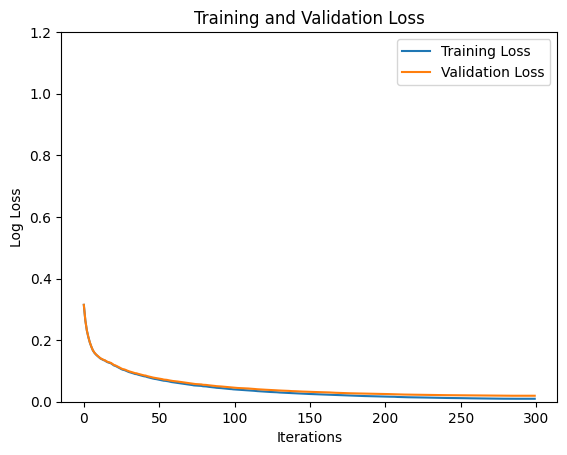

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.load_model("xgb_weight.json")

with open("xgb_loss.json", "r") as f:
    evals_result = json.load(f)


train_loss = evals_result['validation_0']['logloss']
val_loss = evals_result['validation_1']['logloss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0,1.2)
plt.show()


In [ ]:
Y_train = np.array(Y_train).astype(int)
Y_val = np.array(Y_val).astype(int)


In [ ]:
def dnn_model(input_dim):
    model = Sequential()

    model.add(Dense(1024, input_dim=input_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(512, input_dim=input_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())


    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.0004),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

dnn_model = dnn_model(X_train.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)



class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights_dict)

history = dnn_model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, Y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

dnn_model.save('ann_model_1024.h5')
print("Luu mo hinh 'ann_model_1024.h5'.")



history_data = {
    "loss": history.history['loss'],
    "val_loss": history.history['val_loss']
}

with open('loss_history_1024.json', 'w') as f:
    json.dump(history_data, f)
print("Luu loss cua mo hinh 'loss_history_1024.json'.")


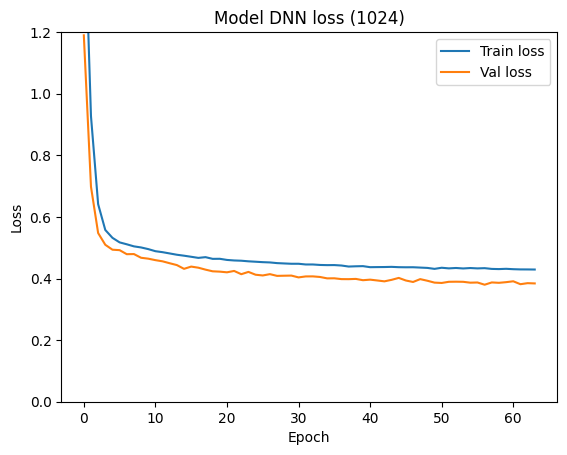

In [ ]:
from tensorflow.keras.models import load_model
import json

# dnn_model = load_model('ann_model_256.h5')
# dnn_model = load_model('dnn_model_512.h5')
dnn_model = load_model('ann_model_1024.h5')

# with open('loss_history_256.json', 'r') as f:
# with open('loss_history_512.json', 'r') as f:
with open('loss_history_1024.json', 'r') as f:
    loaded_history = json.load(f)

plt.plot(loaded_history['loss'], label='Train loss')
plt.plot(loaded_history['val_loss'], label='Val loss')
# plt.title('Model DNN loss (256)')
# plt.title('Model DNN loss (512)')
plt.title('Model DNN loss (1024)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.ylim(0, 1.2)


plt.show()

In [ ]:
from sklearn.utils import resample

neg_val = np.where(Y_val == 0)[0]
pos_val = np.where(Y_val == 1)[0]

X_val_pos = X_val[pos_val]
Y_val_pos = Y_val.iloc[pos_val]

X_val_neg, Y_val_neg = resample(X_val[neg_val],
                                         Y_val.iloc[neg_val],
                                         replace=False,
                                         n_samples=len(pos_val),
                                         random_state=42)

X_val=np.concatenate([X_val_neg,X_val_pos], axis=0)
Y_val=pd.concat([Y_val_neg,Y_val_pos], axis=0)
# X_val = np.vstack((X_val_neg, X_val_pos))
# Y_val = np.hstack((Y_val_neg, Y_val_pos))

In [ ]:
#Trả lại tập validaion mất cân bằng
X_val=X_val_temp
Y_val=Y_val_temp

Nguong tot nhat cho mo hinh logistic: 0.5298 (AUC = 0.6076)


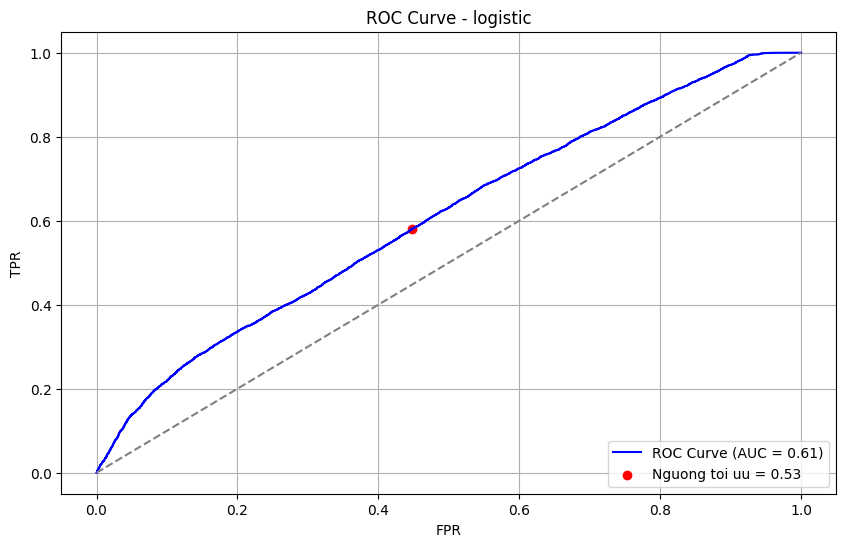


Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.55      0.56     10070
           1       0.56      0.58      0.57     10070

    accuracy                           0.57     20140
   macro avg       0.57      0.57      0.57     20140
weighted avg       0.57      0.57      0.57     20140



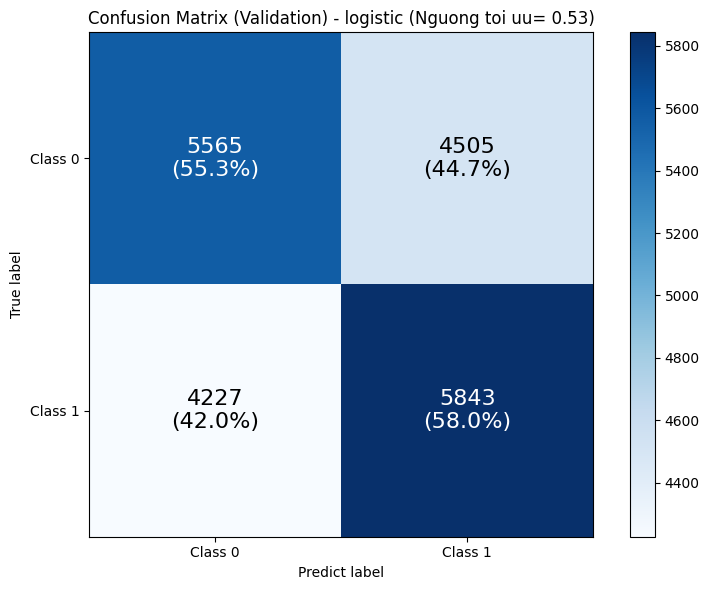

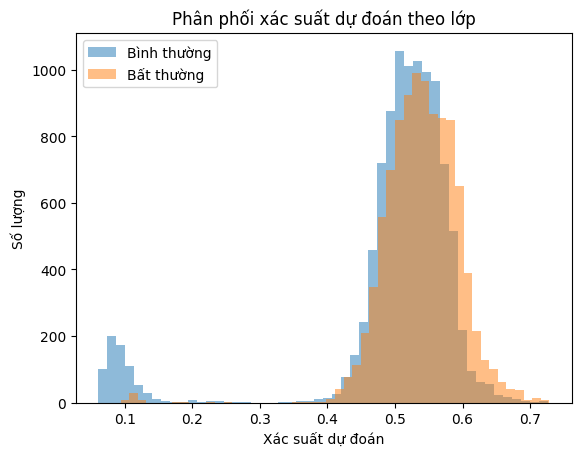

Nguong tot nhat cho mo hinh XGB: 0.0597 (AUC = 0.9920)


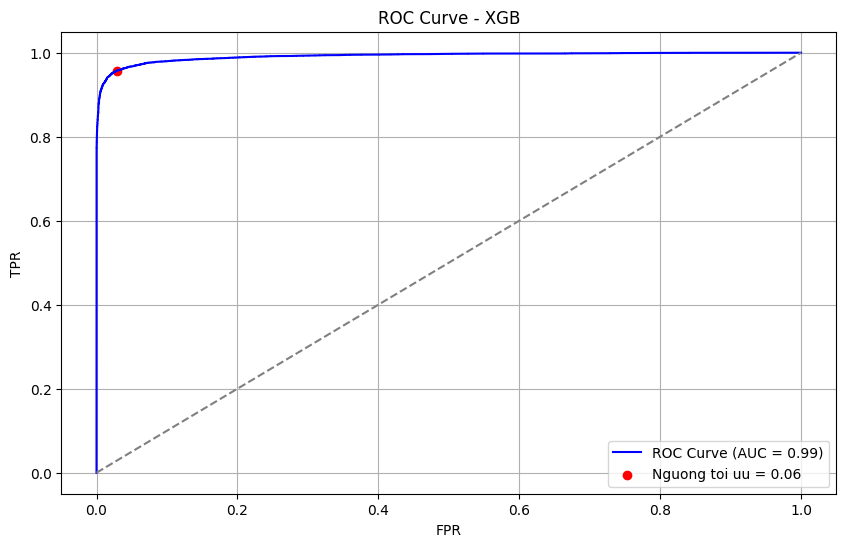


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     10070
           1       0.97      0.96      0.96     10070

    accuracy                           0.96     20140
   macro avg       0.96      0.96      0.96     20140
weighted avg       0.96      0.96      0.96     20140



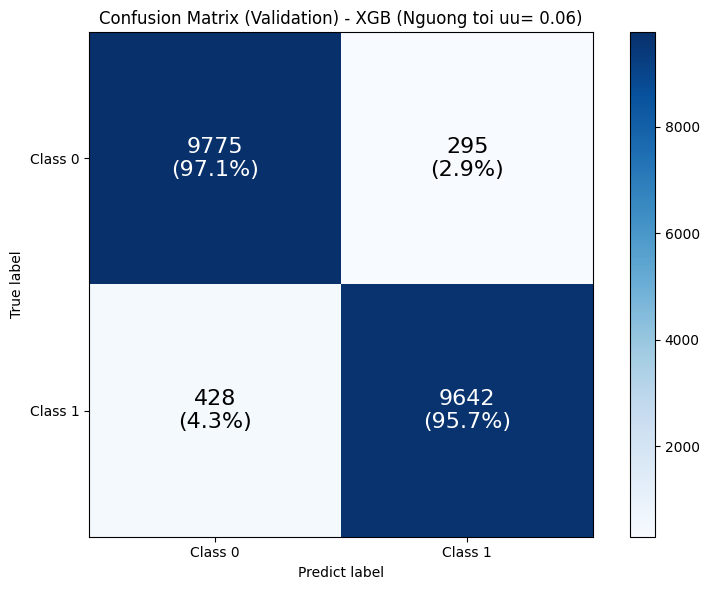

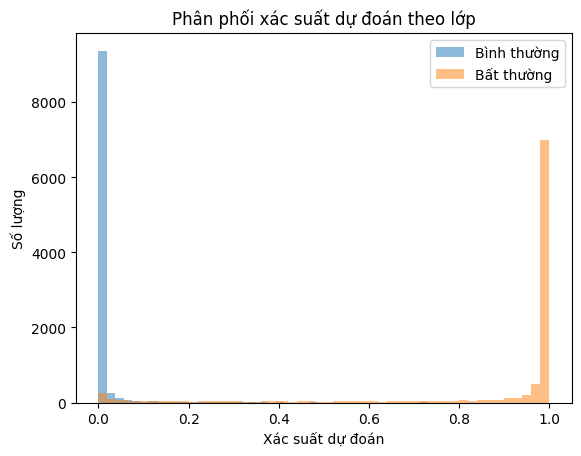

630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Nguong tot nhat cho mo hinh DNN: 0.7135 (AUC = 0.8215)


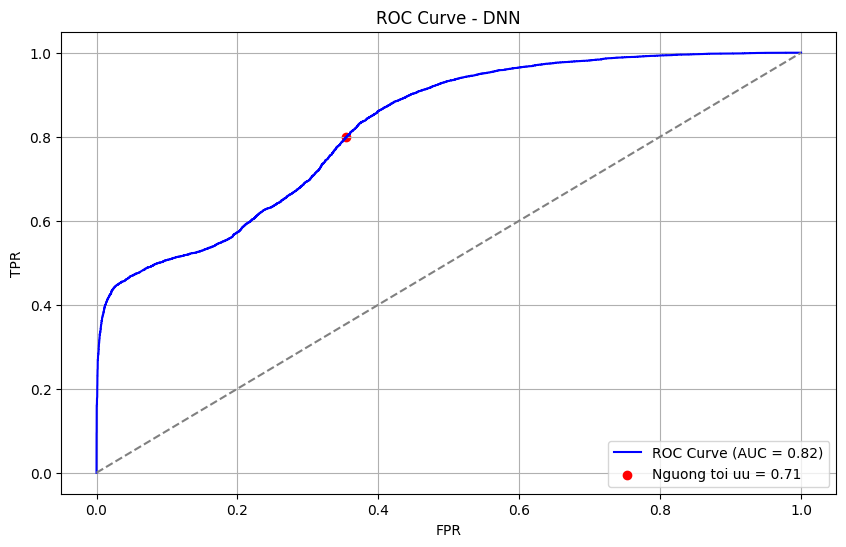


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70     10070
           1       0.69      0.80      0.74     10070

    accuracy                           0.72     20140
   macro avg       0.73      0.72      0.72     20140
weighted avg       0.73      0.72      0.72     20140



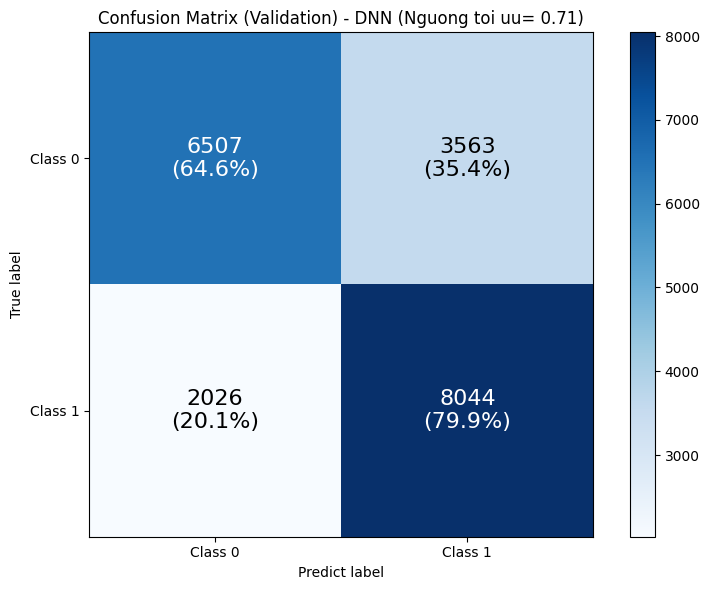

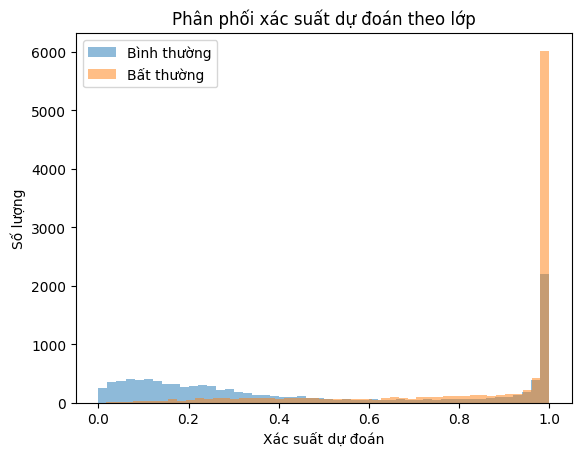

In [ ]:
models = [logistic_model, xgb_model, dnn_model]
model_names = ['logistic', 'XGB', 'DNN']

models = [(logistic_model, model_names[0]),
          (xgb_model, model_names[1]),
          (dnn_model, model_names[2])]

for model, model_name in models:
    if model_name == 'DNN':
        val_pred_prob = model.predict(X_val)
        if val_pred_prob.ndim == 2:
            val_pred_prob = val_pred_prob[:, 0]
    elif model_name == 'logistic':
        val_pred_prob = predict_logis(X_val, model)
    else:  # XGBoost
        val_pred_prob = model.predict_proba(X_val)[:, 1]

    fpr, tpr, thresholds = roc_curve(Y_val, val_pred_prob)
    roc_auc = auc(fpr, tpr)

    distances = np.sqrt((1 - tpr)**2 + fpr**2)
    optimal_idx = np.argmin(distances)
    optimal_threshold = thresholds[optimal_idx]

    print(f"Nguong tot nhat cho mo hinh {model_name}: {optimal_threshold:.4f} (AUC = {roc_auc:.4f})")

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Nguong toi uu = {optimal_threshold:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    val_pred_optimal = (val_pred_prob >= optimal_threshold).astype(int)

    print("\nClassification Report:")
    print(classification_report(Y_val, val_pred_optimal))

    cm = confusion_matrix(Y_val, val_pred_optimal)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    classes = ['Class 0', 'Class 1']
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=f'Confusion Matrix (Validation) - {model_name} (Nguong toi uu= {optimal_threshold:.2f})',
           ylabel='True label',
           xlabel='Predict label')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)",
                    fontsize=16,
                    ha="center", va="center",
                    color="white" if cm[i, j] > 5200 else "black")

    plt.tight_layout()
    plt.show()

    plt.hist(val_pred_prob[Y_val == 0], bins=50, alpha=0.5, label="Bình thường")
    plt.hist(val_pred_prob[Y_val == 1], bins=50, alpha=0.5, label="Bất thường")
    plt.xlabel("Xác suất dự đoán")
    plt.ylabel("Số lượng")
    plt.legend()
    plt.title("Phân phối xác suất dự đoán theo lớp")
    plt.show()



In [ ]:
neg_test=np.where(Y_test==0)[0]
pos_test=np.where(Y_test==1)[0]

X_test_pos=X_test[pos_test]
Y_test_pos=Y_test.iloc[pos_test]

X_test_neg, Y_test_neg=resample(
    X_test[neg_test],
    Y_test.iloc[neg_test],
    replace=False,
    n_samples=len(pos_test),
    random_state=42
)

X_test=np.concatenate([X_test_neg, X_test_pos], axis=0)
Y_test=pd.concat([Y_test_neg, Y_test_pos], axis=0)


              precision    recall  f1-score   support

           0       0.56      0.54      0.55      1119
           1       0.56      0.58      0.57      1119

    accuracy                           0.56      2238
   macro avg       0.56      0.56      0.56      2238
weighted avg       0.56      0.56      0.56      2238



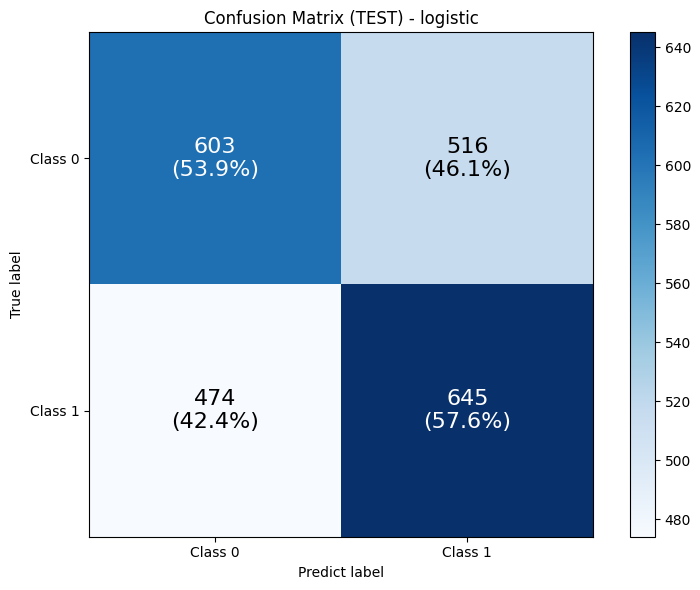

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1119
           1       0.96      0.95      0.96      1119

    accuracy                           0.96      2238
   macro avg       0.96      0.96      0.96      2238
weighted avg       0.96      0.96      0.96      2238



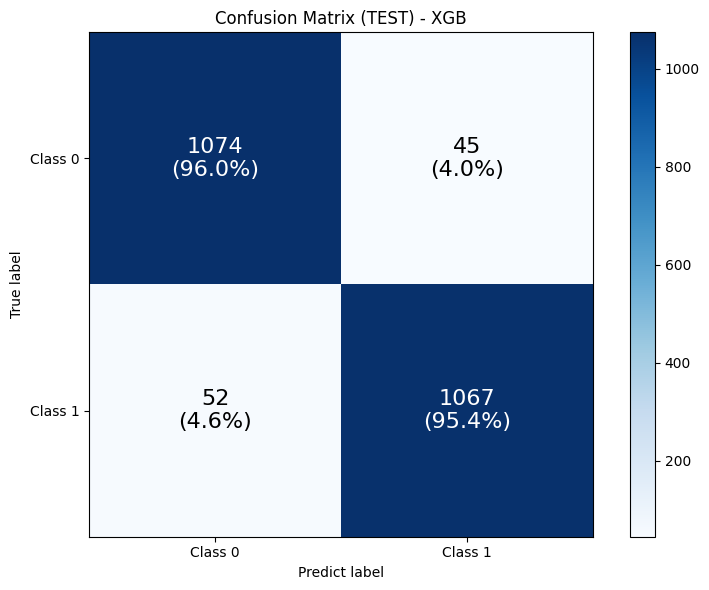

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.77      0.67      0.71      1119
           1       0.71      0.80      0.75      1119

    accuracy                           0.73      2238
   macro avg       0.74      0.73      0.73      2238
weighted avg       0.74      0.73      0.73      2238



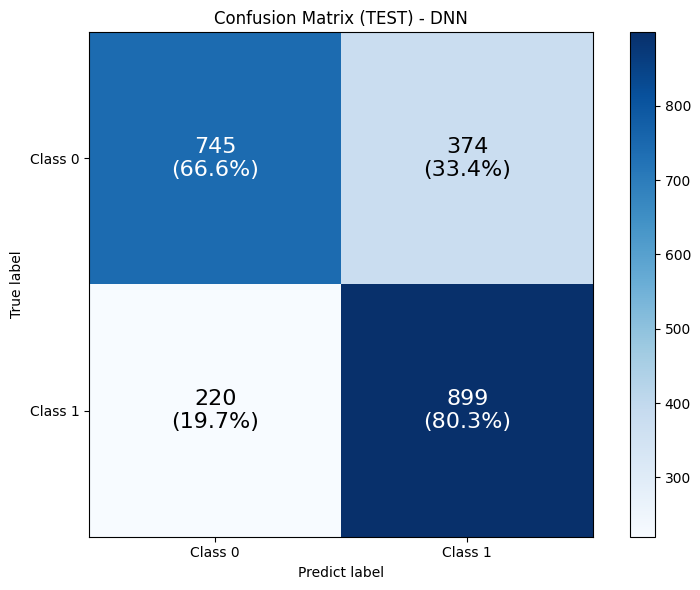

In [ ]:
for i,model in enumerate(models):
    model_name=model_names[i]
    if i==0:
        y_pred_prob=predict_logis(X_test,logistic_model)
        y_pred=(y_pred_prob>=0.53).astype(int)
    elif i==1:
        y_pred_prob=model[0].predict_proba(X_test)[:,1]
        y_pred=(y_pred_prob>=0.06).astype(int)
    else:
        y_pred_prob=model[0].predict(X_test)
        y_pred=(y_pred_prob>=0.7).astype(int)

    precision=precision_score(Y_test,y_pred)
    recall=recall_score(Y_test,y_pred)
    conf_matrix=confusion_matrix(Y_test,y_pred)


    print(classification_report(Y_test,y_pred))

    fig,ax=plt.subplots(figsize=(8,6))
    im=ax.imshow(conf_matrix,interpolation='nearest',cmap='Blues')
    ax.figure.colorbar(im,ax=ax)

    classes=['Class 0','Class 1']
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=classes,yticklabels=classes,
           title=f'Confusion Matrix (TEST) - {model_name}',
           ylabel='True label',
           xlabel='Predict label')

    thresh=conf_matrix.max()/2.
    for j in range(conf_matrix.shape[0]):
        for k in range(conf_matrix.shape[1]):
            percentage=conf_matrix[j,k]/conf_matrix[j].sum()*100
            ax.text(k,j,f"{conf_matrix[j,k]}\n({percentage:.1f}%)",
                    fontsize=16,
                    ha="center",va="center",
                    color="white" if conf_matrix[j,k]>600 else "black")

    plt.tight_layout()
    plt.show()

In [ ]:
choose_test=0
# choose_test=1


anomaly_test=np.where(Y_test==1)[0]
normal_test=np.where(Y_test==0)[0]

random=np.random.choice(anomaly_test) if (choose_test==1) else np.random.choice(normal_test)
print(random)

sample=X_test_total.iloc[random]
sample_scaled=X_test[random]
actual_label=Y_test.iloc[random]
print(actual_label)

building_id=test_data.iloc[random]['building_id']
primary_use_map=['Education','Office','Parking','Lodging/residential',
                 'Entertainment/public assembly','Public services',
                 'Manufacturing/industrial','Services','Other',
                 'Healthcare','Food sales and service','Religious worship']
primary_use=primary_use_map[int(sample['primary_use_label'])]
meter_reading=sample['meter_reading']
hour=int(sample['time'])
day=int(sample['day'])
month=int(sample['month'])
year=2016
weekend_label="ngày cuối tuần" if int(sample['weekend'])==1 else "ngày bình thường"
square_feet=int(sample['square_feet'])

predicted_prob_logis=predict_logis(sample_scaled.reshape(1,-1),logistic_model)
predicted_label_logis=(predicted_prob_logis>=0.53).astype(int)[0]

predicted_prob_dnn=dnn_model.predict(sample_scaled.reshape(1,-1))[0][0]
predicted_label_dnn=(predicted_prob_dnn>=0.08).astype(int)

predicted_prob_xgb=xgb_model.predict_proba(sample_scaled.reshape(1,-1))
predicted_label_xgb=(predicted_prob_xgb>=0.7).astype(int)

predicted_status_logis="bình thường" if predicted_label_logis==0 else "bất thường"
predicted_status_dnn="bình thường" if predicted_label_dnn==0 else "bất thường"
predicted_status_xgb="bình thường" if predicted_label_xgb[0][1]==0 else "bất thường"

print(f"Tòa nhà {building_id} có chỉ số điện năng {meter_reading} kWh, thời gian: {hour}:00, "
      f"{day}/{month}/{year} ({weekend_label}),\nLoại tòa nhà: {primary_use}, "
      f"\nDiện tích: {square_feet} feet2.\n")
print(f"Kết quả dự đoán của các mô hình:")
print(f"- Logistic: {predicted_status_logis} (xác suất: {predicted_prob_logis[0]:})")
print(f"- DNN: {predicted_status_dnn} (xác suất: {predicted_prob_dnn:})")
print(f"- XGBoost: {predicted_status_xgb} (xác suất: {predicted_prob_xgb[0][1]:})\n")
print(f"Thực tế: {'Bình thường' if actual_label==0 else 'Bất thường'}.")


539
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Tòa nhà 968.0 có chỉ số điện năng 177.0 kWh, thời gian: 0:00, 9/5/2016 (ngày bình thường),
Loại tòa nhà: Education, 
Diện tích: 153999 feet2.

Kết quả dự đoán của các mô hình:
- Logistic: bất thường (xác suất: 0.538932488203164)
- DNN: bình thường (xác suất: 0.051527418196201324)
- XGBoost: bình thường (xác suất: 1.5208203876682092e-05)

Thực tế: Bình thường.


_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________########################################################################################################################################################################################################################________________________________________________________________________________________________________________________________________________________________________________________